## 2030StateScenario_AvgRenew: Generator parameters and profiles

Renewable generation profiles are zonal average profiles instead of site-wise profiles.

This notebook writes (9):

* gen_prop.csv
* genfuel_prop.csv
* gencost_prop.csv
* thermal_params.csv
* genmax_profile_{year}.csv
* genmin_profile_{year}.csv
* gencost0_profile_{year}.csv
* gencost1_profile_{year}.csv
* gencost_startup_profile_{year}.csv

The following files need to be created separately (7):

* bus_prop.csv
* branch_prop.csv
* dcline_prop.csv
* esr_prop.csv
* if_lims_prop.csv
* if_map_prop.csv
* load_profile_{year}.csv

In [131]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

import nygrid.gen_params as gp

In [132]:
# Set up directories
cwd = os.getcwd()
if 'examples' in cwd:
    parent_dir = os.path.dirname(cwd)
    data_dir = os.path.join(parent_dir, 'data')
else:
    data_dir = os.path.join(cwd, 'data')

grid_data_dir = os.path.join(data_dir, 'grid')
if not os.path.exists(grid_data_dir):
    raise FileNotFoundError('Grid data directory not found.')

thermal_data_dir = os.path.join(data_dir, 'thermal')
if not os.path.exists(thermal_data_dir):
    raise FileNotFoundError('Thermal data directory not found.')

print('Grid data directory: {}'.format(grid_data_dir))
print('Thermal data directory: {}'.format(thermal_data_dir))

solar_data_dir = os.path.join(data_dir, 'renewable', 'solar')
print('Solar data directory: {}'.format(solar_data_dir))

onshore_wind_data_dir = os.path.join(data_dir, 'renewable', 'onshore_wind')
print('Onshore wind data directory: {}'.format(onshore_wind_data_dir))

offshore_wind_data_dir = os.path.join(data_dir, 'renewable', 'offshore_wind')
print('Offshore wind data directory: {}'.format(offshore_wind_data_dir))

load_data_dir = os.path.join(data_dir, 'load')
print('Load data directory: {}'.format(load_data_dir))

nyiso_data_dir = os.path.join(data_dir, 'from_nyiso')
print('NYISO data directory: {}'.format(nyiso_data_dir))

Grid data directory: /mnt/Bo_HDD/NYgrid-python/data/grid
Thermal data directory: /mnt/Bo_HDD/NYgrid-python/data/thermal
Solar data directory: /mnt/Bo_HDD/NYgrid-python/data/renewable/solar
Onshore wind data directory: /mnt/Bo_HDD/NYgrid-python/data/renewable/onshore_wind
Offshore wind data directory: /mnt/Bo_HDD/NYgrid-python/data/renewable/offshore_wind
Load data directory: /mnt/Bo_HDD/NYgrid-python/data/load
NYISO data directory: /mnt/Bo_HDD/NYgrid-python/data/from_nyiso


# Read generator parameters

In [133]:
# Read processed generator parameters
thermal_params_df = pd.read_excel(os.path.join(
    thermal_data_dir, 'gen_params_2018.xlsx'), index_col=0)
thermal_params_df_2 = pd.read_excel(os.path.join(
    thermal_data_dir, 'gen_params_2024.xlsx'), index_col=0)
thermal_params_df = pd.concat([thermal_params_df, thermal_params_df_2], axis=0)

In [134]:
# 2024 NYCA: 218 thermal generators
gen_combiner_2024 = pd.read_excel(os.path.join(thermal_data_dir, '2024_nyca_thermal.xlsx'),
                                  sheet_name='matched_with_id_filtered')
gen_combiner_2024 = gen_combiner_2024.rename(columns={
    '   Station        Unit': 'NYISO_Name'})

# Map unit type GT, JE to CT
gen_combiner_2024['Unit Type'] = gen_combiner_2024['Unit Type'].replace(
    {'GT': 'CT', 'JE': 'CT'})
gen_combiner_2024['Fuel Type Secondary'] = gen_combiner_2024['Fuel Type Secondary'].astype(
    str).replace({'nan': ''})
gen_combiner_2024 = gen_combiner_2024.set_index('ID')
gen_combiner_2024 = gen_combiner_2024.sort_values(
    by=['CAMD_Plant_ID', 'CAMD_Unit_ID'])

thermal_params_2024 = thermal_params_df.loc[gen_combiner_2024.index]
thermal_params_2024 = thermal_params_2024.join(
    gen_combiner_2024[['Zone', 'gen_bus']])
thermal_params_2024 = thermal_params_2024[[
    'NYISO_Name', 'PTID', 'Unit_Type', 'Fuel_Type_Primary',
    'Fuel_Type_Secondary', 'CAMD_Plant_ID', 'CAMD_Unit_ID',
    'raise_rr_ratio', 'lower_rr_ratio',
    'max_gen', 'eco_min', 'eco_min_ratio',
    'heat_1', 'heat_0', 'gen_bus', 'Zone'
]]

# Calculate ramp rates
thermal_params_2024['max_ramp_ratio'] = thermal_params_2024[[
    'raise_rr_ratio', 'lower_rr_ratio']].max(axis=1)
thermal_params_2024['max_ramp_hourly'] = thermal_params_2024['max_ramp_ratio'] * \
    thermal_params_2024['max_gen']

# Sort by CAMD plant and unit ID
thermal_params_2024 = thermal_params_2024.sort_values(
    by=['CAMD_Plant_ID', 'CAMD_Unit_ID'])
thermal_params_2024 = thermal_params_2024.reset_index()

# Format generator properties

## 1. Thermal generators (CC, CT, ST)

In [135]:
# 11 gas turbines are retired due to Peaker rule
retire_peaker_names = [
    "Brentwood",
    "Gowanus 5",
    "Gowanus 6",
    "Harlem River 1",
    "Harlem River 2",
    "Hellgate 1",
    "Hellgate 2",
    "Kent",
    "Pouch",
    "Vernon Blvd 2",
    "Vernon Blvd 3",
]

age_before_1960_names = [
    'Jamestown 5',
    'East River 6',
    'Danskammer 1',
    'Greenidge 4 (BTM:NG)',
    'Astoria 2',
    'Danskammer 2',
    'East River 7',
    'Barrett ST 01',
    'Astoria 3',
    'Port Jefferson 3',
    'Arthur Kill ST 2',
    'Danskammer 3'
]

age_before_1970_names = [
    'Astoria 5',
    'Ravenswood ST 01',
    'Ravenswood ST 02',
    'Barrett ST 02',
    'Ravenswood ST 03',
    'Port Jefferson GT 01',
    'Northport GT',
    'Glenwood GT 01',
    'Astoria GT 01',
    'Northport 1',
    'Danskammer 4',
    'Northport 2',
    'Jamestown 6',
    '74 St.  GT 1',
    '74 St.  GT 2',
    '59 St.  GT 1',
    'Arthur Kill ST 3'
]

# Combine all retired generators
retire_names = (
    retire_peaker_names 
    + age_before_1960_names 
    + age_before_1970_names
)

# Remove the retired generators
thermal_params_2030 = thermal_params_2024[~thermal_params_2024['NYISO_Name'].isin(retire_names)]
thermal_params_2030 = thermal_params_2030.reset_index(drop=True)

In [136]:
# 2030 NYCA: 181 thermal generators
thermal_prop_2030 = gp.format_gen_prop_thermal(thermal_params_2030)

## 2. Nuclear

In [137]:
# Read nuclear generator parameters
nuclear_params_2024 = pd.read_excel(os.path.join(thermal_data_dir, '2024_nyca_nonthermal.xlsx'),
                                    sheet_name='Nuclear')
nuclear_params_2024['Unit Type'] = nuclear_params_2024['Unit Type'].replace(
    {'NP': 'NU', 'NB': 'NU'})
nuclear_params_2024['max_ramp_hourly'] = 0.2 * \
    nuclear_params_2024['Capacity (MW)']

# 2030 NYCA: 4 nuclear generators
# Assume the same parameters for 2030 as 2024
nuclear_params_2030 = nuclear_params_2024.copy()
nuclear_prop_2030 = gp.format_gen_prop_non_thermal(nuclear_params_2030)

## 3. Hydro

In [138]:
# Read hydro generator parameters
hydro_params_2024 = pd.read_excel(os.path.join(thermal_data_dir, '2024_nyca_nonthermal.xlsx'),
                                  sheet_name='Hydro')
hydro_params_2024['max_ramp_hourly'] = hydro_params_2024['Capacity (MW)']

# 2030 NYCA: 10 hydro generators
# Assume the same parameters for 2030 as 2024
hydro_params_2030 = hydro_params_2024.copy()
hydro_prop_2030 = gp.format_gen_prop_non_thermal(hydro_params_2024)

## 4. Import

In [139]:
# Read import generator parameters
import_params_2024 = pd.read_excel(os.path.join(thermal_data_dir, '2024_nyca_nonthermal.xlsx'),
                                   sheet_name='Import')
# For 2030 and onwards, Add CHPE as a generator in NYC
chpe_row = {
    'Name': 'Import_HQ_CHPE',
    'Zone': 'J',
    'PTID': 'NaN',
    'Capacity (MW)': 1250,
    'Unit Type': 'Import',
    'Fuel Type Primary': 'Import',
    '2023 Net Energy (GWh)': 'NaN',
    'Notes': 'NYGRID',
    'min_gen': 0,
    'gen_bus': 81
}
chpe_row = pd.Series(chpe_row)
import_params_2030 = import_params_2024.append(chpe_row, ignore_index=True)

import_params_2030['max_ramp_hourly'] = import_params_2030['Capacity (MW)']

/tmp/ipykernel_2000861/1901271979.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  import_params_2030 = import_params_2024.append(chpe_row, ignore_index=True)


In [140]:
# 2030 NYCA: 16 import generators
import_prop_2030 = gp.format_gen_prop_non_thermal(import_params_2030)

## 5. Wind

In [141]:
# Read county to zone allocation
county_alloc = pd.read_csv(os.path.join(load_data_dir, 'county_2_bus.csv'))
county_2_bus = dict(zip(county_alloc['NAME'], county_alloc['busIdx']))
county_2_zone = dict(zip(county_alloc['NAME'], county_alloc['ZoneID']))

In [142]:
# Read wind generator parameters
wind_params_2024 = pd.read_excel(os.path.join(thermal_data_dir, '2024_nyca_nonthermal.xlsx'),
                                 sheet_name='Wind')
wind_params_2024['max_ramp_hourly'] = wind_params_2024['Capacity (MW)']

In [143]:
# Add wind generators for 2030
# 1. Base case
# 2. Contract case
# 3. State Scenario
# 4. Offshore wind

wind_farms = [
    'lbw_params_outlook_base',
    'lbw_params_outlook_contract',
    'lbw_params_state_scenario_2030',
    'osw_farm_params',
]

osw_2030 = {
    'Empire Offshore Wind , LLC': [2076, 'Kings'],
    'Attentive Energy LLC': [1280, 'Kings'],
    'Sunrise Wind, LLC': [924, 'Nassau'],
    'Beacon Wind LLC': [1230, 'Nassau'],
    'Community Offshore Wind, LLC': [1344, 'Nassau'],
    'Mid-Atlantic Offshore Wind LLC': [1314, 'Nassau'],
}

# Process wind farm parameters
wind_farm_list = []
for group in wind_farms:
    wind_farm = pd.read_excel(os.path.join(data_dir, 'renewable', 'wind_projects.xlsx'),
                              sheet_name=group)

    # Base case: only add High Bridge Wind
    if group == 'lbw_params_outlook_base':
        wind_farm = wind_farm[wind_farm['Name'] == 'High Bridge Wind']

    # Offshore wind
    if group == 'osw_farm_params':
        wind_farm = wind_farm[wind_farm['Name'].isin(osw_2030.keys())]
        wind_farm['p_cap'] = wind_farm['Name'].map(
            lambda x: osw_2030[x][0])
        wind_farm['p_county'] = wind_farm['Name'].map(lambda x: osw_2030[x][1])
        # Remove 'LLC' or ', LLC' from the name
        wind_farm['Name'] = wind_farm['Name'].str.replace('LLC', '').replace(
            ', ', ' ', regex=True).str.strip()
    
    # LBW from NYSERDA supply curve
    if group == 'lbw_params_state_scenario_2030':
        wind_farm['Name'] = 'LBW ' + wind_farm['Name']
    
    wind_farm_list.append(wind_farm)

new_wind_params = pd.concat(wind_farm_list, axis=0)
new_wind_params['Zone'] = new_wind_params['p_county'].map(county_2_zone)
new_wind_params['PTID'] = 'NaN'
new_wind_params['Capacity (MW)'] = new_wind_params['p_cap']
new_wind_params['Unit Type'] = 'WT'
new_wind_params['Fuel Type Primary'] = 'WND'
new_wind_params['2023 Net Energy (GWh)'] = 'NaN'
new_wind_params['Notes'] = 'NYGRID'
new_wind_params['min_gen'] = 0
new_wind_params['gen_bus'] = new_wind_params['p_county'].map(county_2_bus)
new_wind_params['max_ramp_hourly'] = new_wind_params['Capacity (MW)']
new_wind_params = new_wind_params.drop(columns=['p_cap', 'p_county', 'lat', 'lon'])

# Combine with existing wind parameters
wind_params_2030 = pd.concat([wind_params_2024, new_wind_params], axis=0)
wind_params_2030 = wind_params_2030.reset_index(drop=True)

# Drop duplicate
wind_params_2030 = wind_params_2030.drop_duplicates(subset=['Name'])

In [144]:
# 2024 NYCA: 49 wind generators
wind_prop_2030 = gp.format_gen_prop_non_thermal(wind_params_2030)

## 6. Utility PV

In [145]:
# Add UPV generators for 2030
# 1. Base case
# 2. Contract case
# 3. State Scenario
upv_farms = [
    'upv_params_2024_ft',
    'upv_params_2024_sat',
    'upv_params_outlook_base',
    'upv_params_outlook_contract',
    'upv_params_state_scenario_2030',
]

# Process solar farm parameters
upv_farm_list = []
for group in upv_farms:
    upv_farm = pd.read_excel(os.path.join(data_dir, 'renewable', 'solar_projects.xlsx'),
                              sheet_name=group)
    upv_farm = upv_farm[['Name', 'p_cap_ac', 'p_county']]

    # Replace 'St Lawrence' with 'St. Lawrence'
    upv_farm['p_county'] = upv_farm['p_county'].replace(
        {'St Lawrence': 'St. Lawrence'})
    
    # UPV from NYSERDA supply curve
    if group == 'upv_params_state_scenario_2030':
        upv_farm['Name'] = 'UPV ' + upv_farm['Name']
    
    upv_farm_list.append(upv_farm)

upv_params_2030 = pd.concat(upv_farm_list, axis=0)
upv_params_2030['Zone'] = upv_params_2030['p_county'].map(county_2_zone)
upv_params_2030['PTID'] = 'NaN'
upv_params_2030['Capacity (MW)'] = upv_params_2030['p_cap_ac']
upv_params_2030['Unit Type'] = 'PV'
upv_params_2030['Fuel Type Primary'] = 'SUN'
upv_params_2030['2023 Net Energy (GWh)'] = 'NaN'
upv_params_2030['Notes'] = 'NYGRID'
upv_params_2030['min_gen'] = 0
upv_params_2030['gen_bus'] = upv_params_2030['p_county'].map(county_2_bus)
upv_params_2030['max_ramp_hourly'] = upv_params_2030['Capacity (MW)']
upv_params_2030 = upv_params_2030.drop(columns=['p_cap_ac'])

# Combine with existing upv parameters
upv_params_2030 = upv_params_2030.reset_index(drop=True)

# Drop duplicate solar farms
upv_params_2030 = upv_params_2030.drop_duplicates(subset='Name')

# Fill missing values
upv_params_2030.loc[upv_params_2030['Name'] == 'Q1080 UPV RESRFP2022', 'gen_bus'] = 61
upv_params_2030.loc[upv_params_2030['Name'] == 'Q1080 UPV RESRFP2022', 'Zone'] = 61

In [146]:
# 2024 NYCA: 123 UPV generators
upv_prop_2030 = gp.format_gen_prop_non_thermal(upv_params_2030)

## 7. Other renewables

In [147]:
# Read other renewable generator parameters
others_params_2024 = pd.read_excel(os.path.join(thermal_data_dir, '2024_nyca_nonthermal.xlsx'),
                                   sheet_name='Others')
others_params_2024['max_ramp_hourly'] = others_params_2024['Capacity (MW)']

# 2030 NYCA: 18 other renewable generators
# Assume the same parameters for 2030 as 2024
others_params_2030 = others_params_2024.copy()
others_prop_2030 = gp.format_gen_prop_non_thermal(others_params_2024)

## 8. Large Load

In [148]:
# Read large load parameters
large_load_params_2030 = pd.read_csv(os.path.join(load_data_dir, 'large_load.csv'))

for i, row in large_load_params_2030.iterrows():
    if row['Notes'] == 'Data center': # Inflexible load
        large_load_params_2030.at[i, 'Capacity (MW)'] = row['Demand (MW)'] * -0.9
        large_load_params_2030.at[i, 'min_gen'] = row['Demand (MW)'] * -1
    elif row['Notes'] == 'Cryptocurrency mining': # Flexible load
        large_load_params_2030.at[i, 'Capacity (MW)'] = 0
        large_load_params_2030.at[i, 'min_gen'] = row['Demand (MW)'] * -1
    elif row['Notes'] == 'Manufacturing': # Inflexible load
        large_load_params_2030.at[i, 'Capacity (MW)'] = row['Demand (MW)'] * -0.9
        large_load_params_2030.at[i, 'min_gen'] = row['Demand (MW)'] * -1
    elif row['Notes'] == 'Electrolysis': # Flexible load
        large_load_params_2030.at[i, 'Capacity (MW)'] = 0
        large_load_params_2030.at[i, 'min_gen'] = row['Demand (MW)'] * -1
    else: # Flexible load
        large_load_params_2030.at[i, 'Capacity (MW)'] = 0
        large_load_params_2030.at[i, 'min_gen'] = row['Demand (MW)'] * -1

large_load_params_2030['PTID'] = 'NaN'
large_load_params_2030['Unit Type'] = 'Load'
large_load_params_2030['Fuel Type Primary'] = 'Load'
large_load_params_2030['2023 Net Energy (GWh)'] = 'NaN'
large_load_params_2030['gen_bus'] = large_load_params_2030['Bus']
large_load_params_2030['max_ramp_hourly'] = large_load_params_2030['Capacity (MW)']
large_load_params_2030 = large_load_params_2030.drop(columns=['Year', 'Bus', 'County'])

In [149]:
large_load_prop_2030 = gp.format_gen_prop_non_thermal(large_load_params_2030)

## 9. Combine generator properties

In [150]:
# 2030 NYCA: 418 generators
gen_prop_2030 = pd.concat([thermal_prop_2030,
                           nuclear_prop_2030,
                           hydro_prop_2030,
                           import_prop_2030,
                           wind_prop_2030,
                           upv_prop_2030,
                           others_prop_2030,
                           large_load_prop_2030,
                           ], axis=0)

In [151]:
gen_prop_2030

,GEN_NAME,GEN_BUS,PG,QG,QMAX,QMIN,VG,MBASE,GEN_STATUS,PMAX,...,RAMP_10,RAMP_30,RAMP_Q,APF,GEN_ZONE,UNIT_TYPE,FUEL_TYPE,CMT_KEY,MIN_UP_TIME,MIN_DOWN_TIME
0,"Arthur Kill GT 1(2490,CT0001)",82.0,0,0,9999,-9999,1,100,1,15.0,...,2.500000,7.5,0,0,J,CT,NG,1,2,2
1,"East River 1(2493,1)",82.0,0,0,9999,-9999,1,100,1,296.0,...,22.833333,68.5,0,0,J,CC,NG,1,6,4
2,"East River 2(2493,2)",82.0,0,0,9999,-9999,1,100,1,293.0,...,27.666667,83.0,0,0,J,CC,NG,1,6,4
3,"Gowanus 2-1(2494,CT02-1)",82.0,0,0,9999,-9999,1,100,1,16.0,...,2.666667,8.0,0,0,J,CT,FO2,1,2,2
4,"Gowanus 2-2(2494,CT02-2)",82.0,0,0,9999,-9999,1,100,1,16.0,...,2.666667,8.0,0,0,J,CT,FO2,1,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,POWI Project,41.0,0,0,9999,-9999,1,100,1,-45.0,...,-7.500000,-22.5,0,0,F,Load,Load,2,0,0
13,Additional Large Load A,57.0,0,0,9999,-9999,1,100,1,0.0,...,0.000000,0.0,0,0,A,Load,Load,2,0,0
14,Additional Large Load C,51.0,0,0,9999,-9999,1,100,1,0.0,...,0.000000,0.0,0,0,C,Load,Load,2,0,0
15,Additional Large Load D,49.0,0,0,9999,-9999,1,100,1,0.0,...,0.000000,0.0,0,0,D,Load,Load,2,0,0


# Format generator profiles

## 1. genmax profile

### A. Wind

In [152]:
# Land-based wind generation profile at turbine level
onshore_wind_gen = pd.read_csv(os.path.join(onshore_wind_data_dir, f'current_wind_gen_1hr.csv'),
                               parse_dates=['Time'], index_col='Time').asfreq('H')
onshore_wind_gen.columns = onshore_wind_gen.columns.astype(int)

In [153]:
# Read wind turbine information
uswtdb_ny_2024 = pd.read_excel(os.path.join(
    onshore_wind_data_dir, 'uswtdb_2024_ny.xlsx'))

# Create a dict of NYISO name and USWTDB name
wind_names_2024 = dict(zip(wind_params_2024['Notes'],
                           wind_params_2024['Name']))

In [154]:
# 2024 NYCA: 31 wind generators
wind_farm_ts_dict = dict()
for name in wind_names_2024:
    wind_farm_df = uswtdb_ny_2024[uswtdb_ny_2024['p_name'] == name]
    wind_farm_idx = list(wind_farm_df.index)
    wind_farm_ts = onshore_wind_gen.loc[:, wind_farm_idx].sum(axis=1)
    wind_farm_ts_dict[name] = wind_farm_ts
wind_genmax_profile_2024 = pd.DataFrame(wind_farm_ts_dict)

# Remove timezone info
wind_genmax_profile_2024.index = wind_genmax_profile_2024.index.tz_localize(None)

# Convert kW to MW
wind_genmax_profile_2024 = wind_genmax_profile_2024 / 1000

# Rename wind farms
wind_genmax_profile_2024 = wind_genmax_profile_2024.rename(
    columns=wind_names_2024)

In [155]:
wind_farm_gen_list = list()

for group in wind_farms:

    if group == 'osw_farm_params':
        wind_farm_gen = pd.read_csv(os.path.join(offshore_wind_data_dir, f'{group}_wind_gen_1hr_MW.csv'),
                                    parse_dates=['Time'], index_col='Time').asfreq('H')
        wind_farm_gen = wind_farm_gen[osw_2030.keys()]
        
        # The original data is at 1000 MW capacity
        # Scale up according to the capacity in the parameters
        for name in osw_2030:
            wind_farm_gen[name] = wind_farm_gen[name] * osw_2030[name][0] / 1000

        # Remove 'LLC' or ', LLC' from the name
        wind_farm_gen.columns = wind_farm_gen.columns.to_series().str.replace('LLC', '').replace(
            ', ', '', regex=True).str.strip()
    else:
        wind_farm_gen = pd.read_csv(os.path.join(onshore_wind_data_dir, f'{group}_wind_gen_1hr_MW.csv'),
                                    parse_dates=['Time'], index_col='Time').asfreq('H')

        # Base case: only add High Bridge Wind
        if group == 'lbw_params_outlook_base':
            wind_farm_gen = wind_farm_gen[['High Bridge Wind']]

        if group == 'lbw_params_state_scenario_2030':
            wind_farm_gen.columns = wind_farm_gen.columns.map(lambda x: 'LBW ' + x)

    # Apply loss factors
    wind_farm_gen = wind_farm_gen * 0.941 # Wake
    wind_farm_gen = wind_farm_gen * 0.96 # Turbine performance
    wind_farm_gen = wind_farm_gen * 0.973 # Environmental
    wind_farm_gen = wind_farm_gen * 0.975 # Bulk electrical efficiency
    wind_farm_gen = wind_farm_gen * 0.949 # Availability

    wind_farm_gen_list.append(wind_farm_gen)

new_wind_gen = pd.concat(wind_farm_gen_list, axis=1)

In [156]:
# Replace some OSW generation profile with more detailed data
offshore_wind_gen = pd.read_csv(os.path.join(offshore_wind_data_dir, f'power_load_2018.csv'),
                                parse_dates=['timestamp'], index_col='timestamp')
offshore_wind_gen.index = offshore_wind_gen.index.tz_localize(  # type: ignore
    'US/Eastern', ambiguous='infer')
offshore_wind_gen.index.freq = 'H'
empire_wind_gen = offshore_wind_gen['power_nyc']
beacon_wind_gen = offshore_wind_gen['power_li'] * 1230/(1230+924)
sunrise_wind_gen = offshore_wind_gen['power_li'] * 924/(1230+924)

loss_factor = 0.96 * 0.973 * 0.975 * 0.949 # Wake loss was already applied
new_wind_gen['Empire Offshore Wind'] = empire_wind_gen * loss_factor
new_wind_gen['Beacon Wind'] = beacon_wind_gen * loss_factor
new_wind_gen['Sunrise Wind'] = sunrise_wind_gen * loss_factor

# Remove timezone info
new_wind_gen.index = new_wind_gen.index.tz_localize(None)

In [157]:
# 2030 NYCA: 50 wind generators
wind_genmax_profile_2030 = pd.concat([wind_genmax_profile_2024, new_wind_gen], axis=1)

In [158]:
wind2zone_dict = wind_prop_2030.set_index('GEN_NAME')['GEN_ZONE'].to_dict()

# Calculate site-wise capacity factor
wind_cf_profile_2030 = wind_genmax_profile_2030.copy()
for name in wind_cf_profile_2030.columns:
    wind_cf_profile_2030[name] = wind_cf_profile_2030[name] / \
        wind_prop_2030[wind_prop_2030['GEN_NAME'] == name]['PMAX'].values[0]
    # Clip to 0 and 1
    wind_cf_profile_2030[name] = wind_cf_profile_2030[name].clip(0, 1)

# Calculate zonal average capacity factor
wind_cf_profile_zone_2030 = wind_cf_profile_2030.T.groupby(wind2zone_dict).mean().T

# Assign zonal average capacity factor to each wind farm
wind_genmax_profile_avg_2030 = wind_genmax_profile_2030.copy()
for name in wind_genmax_profile_avg_2030.columns:
    wind_genmax_profile_avg_2030[name] = wind_cf_profile_zone_2030[wind2zone_dict[name]] * \
        wind_prop_2030[wind_prop_2030['GEN_NAME'] == name]['PMAX'].values[0]
    
wind_error = wind_genmax_profile_avg_2030 - wind_genmax_profile_2030

<Axes: xlabel='Time'>

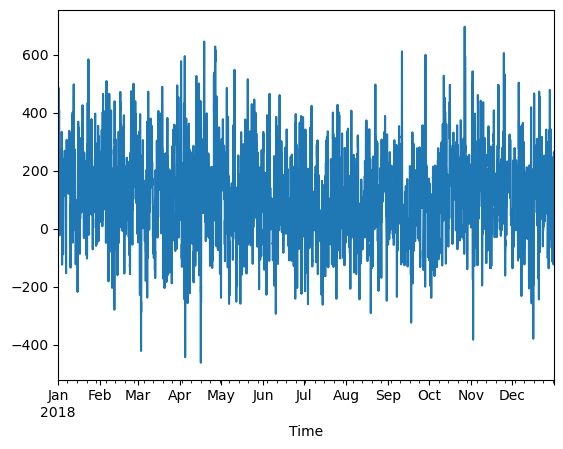

In [159]:
wind_error.sum(axis=1).plot()

### B. Utility PV

In [160]:
# Utility PV generation profile
upv_farm_gen_list = list()
for group in upv_farms:
    upv_farm_gen = pd.read_csv(os.path.join(solar_data_dir, f'{group}_solar_gen_1hr_MW.csv'),
                                 parse_dates=['Time'], index_col='Time').asfreq('H')
    
    if group == 'upv_params_state_scenario_2030':
        upv_farm_gen.columns = upv_farm_gen.columns.map(lambda x: 'UPV ' + x)
    
    upv_farm_gen_list.append(upv_farm_gen)

upv_genmax_profile_2030 = pd.concat(upv_farm_gen_list, axis=1)

# Remove timezone info
upv_genmax_profile_2030.index = upv_genmax_profile_2030.index.tz_localize(None)

# Remove duplicate columns
upv_genmax_profile_2030 = upv_genmax_profile_2030.loc[:, ~upv_genmax_profile_2030.columns.duplicated()]

In [161]:
upv2zone_dict = upv_prop_2030.set_index('GEN_NAME')['GEN_ZONE'].to_dict()

# Calculate site-wise capacity factor
upv_cf_profile_2030 = upv_genmax_profile_2030.copy()
for name in upv_cf_profile_2030.columns:
    upv_cf_profile_2030[name] = upv_cf_profile_2030[name] / \
        upv_prop_2030[upv_prop_2030['GEN_NAME'] == name]['PMAX'].values[0]
    # Clip to 0 and 1
    upv_cf_profile_2030[name] = upv_cf_profile_2030[name].clip(0, 1)

# Calculate zonal average capacity factor
upv_cf_profile_zone_2030 = upv_cf_profile_2030.T.groupby(upv2zone_dict).mean().T

# Assign zonal average capacity factor to each wind farm
upv_genmax_profile_avg_2030 = upv_genmax_profile_2030.copy()
for name in upv_genmax_profile_avg_2030.columns:
    upv_genmax_profile_avg_2030[name] = upv_cf_profile_zone_2030[upv2zone_dict[name]] * \
        upv_prop_2030[upv_prop_2030['GEN_NAME'] == name]['PMAX'].values[0]
    
upv_error = upv_genmax_profile_avg_2030 - upv_genmax_profile_2030

<Axes: xlabel='Time'>

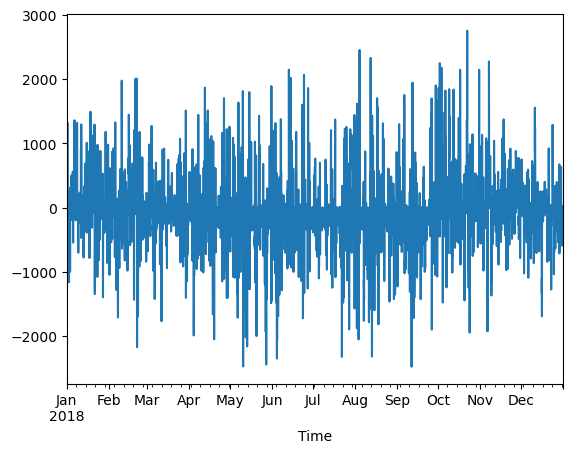

In [162]:
upv_error.sum(axis=1).plot()

### C. Import

In [163]:
# Read NYISO historical interface flow data
interflow_2018 = pd.read_csv(os.path.join(nyiso_data_dir, 'interflowHourly_2018.csv'),
                             parse_dates=['TimeStamp'])
interflow_2018 = interflow_2018.pivot(
    index='TimeStamp', columns='InterfaceName', values='FlowMWH')

# Internal interface flow
if_internal_2018 = interflow_2018[['CENTRAL EAST - VC', 'DYSINGER EAST', 'MOSES SOUTH',
                                  'SPR/DUN-SOUTH', 'TOTAL EAST', 'UPNY CONED', 'WEST CENTRAL']]

# External interface flow
if_external_2018 = interflow_2018[['SCH - HQ - NY', 'SCH - HQ_CEDARS', 'SCH - HQ_IMPORT_EXPORT',
                                  'SCH - NE - NY', 'SCH - NPX_1385', 'SCH - NPX_CSC',
                                   'SCH - OH - NY', 'SCH - PJ - NY', 'SCH - PJM_HTP',
                                   'SCH - PJM_NEPTUNE', 'SCH - PJM_VFT']]

In [164]:
# Assume that 2030 import generators have the same capacity as 2018
# 2018 NYCA: 15 import generators
import_genmax_profile_2030 = pd.DataFrame(index=if_external_2018.index)

# NE
import_genmax_profile_2030['Import_NE_CSC'] = if_external_2018['SCH - NPX_CSC']
import_genmax_profile_2030['Import_NE_NNC'] = if_external_2018['SCH - NPX_1385']
import_genmax_profile_2030['Import_NE_ZF'] = if_external_2018['SCH - NE - NY'] * 0.5
import_genmax_profile_2030['Import_NE_ZG'] = if_external_2018['SCH - NE - NY'] * 0.5

# IESO
import_genmax_profile_2030['Import_IESO_ZD'] = if_external_2018['SCH - OH - NY'] * 0.16
import_genmax_profile_2030['Import_IESO_ZA1'] = if_external_2018['SCH - OH - NY'] * 0.42
import_genmax_profile_2030['Import_IESO_ZA2'] = if_external_2018['SCH - OH - NY'] * 0.42

# PJM
import_genmax_profile_2030['Import_PJM_ZA'] = if_external_2018['SCH - PJ - NY'] * 0.175
import_genmax_profile_2030['Import_PJM_ZC'] = if_external_2018['SCH - PJ - NY'] * 0.285
import_genmax_profile_2030['Import_PJM_ZG'] = if_external_2018['SCH - PJ - NY'] * 0.54
import_genmax_profile_2030['Import_PJM_NEPTUNE'] = if_external_2018['SCH - PJM_NEPTUNE']
import_genmax_profile_2030['Import_PJM_HTP'] = if_external_2018['SCH - PJM_HTP']
import_genmax_profile_2030['Import_PJM_VFT'] = if_external_2018['SCH - PJM_VFT']

# HQ
import_genmax_profile_2030['Import_HQ_CEDARS'] = if_external_2018['SCH - HQ_CEDARS']
import_genmax_profile_2030['Import_HQ_NY'] = if_external_2018['SCH - HQ - NY']

In [165]:
for name in import_params_2030['Name']:
    if name =='Import_HQ_CHPE':
        continue
    p_max = import_params_2030.loc[import_params_2030['Name']
                                   == name, 'Capacity (MW)'].values[0]
    p_min = import_params_2030.loc[import_params_2030['Name']
                                   == name, 'min_gen'].values[0]
    import_genmax_profile_2030[name] = import_genmax_profile_2030[name].clip(
        p_min, p_max)

In [166]:
# 2024 NYCA: 16 import generators
import_genmax_profile_2030 = import_genmax_profile_2030.copy()

# Add CHPE
import_genmax_profile_2030['Import_HQ_CHPE'] = 1250

### D. Other renewables

In [167]:
# 2024 NYCA: 18 other renewable generators
# Assume that 2030 other renewable generators have the same capacity as 2018
others_genmax_profile_2030 = pd.read_excel(os.path.join(thermal_data_dir, '2018_profiles.xlsx'),
                                           sheet_name='Others_GenMax')
others_genmax_profile_2030 = others_genmax_profile_2030.set_index('TimeStamp')

### E. Combine genmax profiles

In [168]:
start_date = datetime(2018, 1, 1, 0, 0, 0)
end_date = datetime(2018, 12, 31, 23, 0, 0)
timestamp_list = pd.date_range(start_date, end_date, freq='1H')

In [169]:
thermal_genmax_profile_2030 = pd.DataFrame(
    np.tile(thermal_prop_2030['PMAX'].values, (8760, 1)),
    index=timestamp_list,
    columns=thermal_prop_2030['GEN_NAME'].values)

In [170]:
nuclear_genmax_profile_2030 = pd.DataFrame(
    np.tile(nuclear_prop_2030['PMAX'].values, (8760, 1)),
    index=timestamp_list,
    columns=nuclear_prop_2030['GEN_NAME'].values)

In [171]:
hydro_genmax_profile_2030 = pd.DataFrame(
    np.tile(hydro_prop_2030['PMAX'].values, (8760, 1)),
    index=timestamp_list,
    columns=hydro_prop_2030['GEN_NAME'].values)

In [172]:
large_load_genmax_profile_2030 = pd.DataFrame(
    np.tile(large_load_prop_2030['PMAX'].values, (8760, 1)),
    index=timestamp_list,
    columns=large_load_prop_2030['GEN_NAME'].values)

In [173]:
genmax_profile_2030 = pd.concat([thermal_genmax_profile_2030,
                                 nuclear_genmax_profile_2030,
                                 hydro_genmax_profile_2030,
                                 import_genmax_profile_2030,
                                 wind_genmax_profile_avg_2030, # NOTE: Replaced with average profile
                                 upv_genmax_profile_avg_2030, # NOTE: Replaced with average profile
                                 others_genmax_profile_2030,
                                 large_load_genmax_profile_2030,
                                 ], axis=1)

## 2. gen min profile

In [174]:
thermal_genmin_profile_2030 = pd.DataFrame(
    np.tile(thermal_prop_2030['PMIN'].values, (8760, 1)),
    index=timestamp_list,
    columns=thermal_prop_2030['GEN_NAME'].values)

In [175]:
nuclear_genmin_profile_2030 = pd.DataFrame(
    np.tile(nuclear_prop_2030['PMIN'].values, (8760, 1)),
    index=timestamp_list,
    columns=nuclear_prop_2030['GEN_NAME'].values)

In [176]:
hydro_genmin_profile_2030 = pd.DataFrame(
    np.tile(hydro_prop_2030['PMIN'].values, (8760, 1)),
    index=timestamp_list,
    columns=hydro_prop_2030['GEN_NAME'].values)

In [177]:
import_genmin_profile_2030 = import_genmax_profile_2030.copy()

for name in import_params_2030['Name']:
    import_genmin_profile_2030[name] = np.where(import_genmin_profile_2030[name] < 0,
                                                import_genmin_profile_2030[name],
                                                0)

In [178]:
wind_genmin_profile_2030 = pd.DataFrame(
    np.tile(wind_prop_2030['PMIN'].values, (8760, 1)),
    index=timestamp_list,
    columns=wind_prop_2030['GEN_NAME'].values)

In [179]:
upv_genmin_profile_2030 = pd.DataFrame(
    np.tile(upv_prop_2030['PMIN'].values, (8760, 1)),
    index=timestamp_list,
    columns=upv_prop_2030['GEN_NAME'].values)

In [180]:
others_genmin_profile_2030 = pd.DataFrame(
    np.tile(others_prop_2030['PMIN'].values, (8760, 1)),
    index=timestamp_list,
    columns=others_prop_2030['GEN_NAME'].values)

In [181]:
large_load_genmin_profile_2030 = pd.DataFrame(
    np.tile(large_load_prop_2030['PMIN'].values, (8760, 1)),
    index=timestamp_list,
    columns=large_load_prop_2030['GEN_NAME'].values)

In [182]:
genmin_profile_2030 = pd.concat([thermal_genmin_profile_2030,
                                 nuclear_genmin_profile_2030,
                                 hydro_genmin_profile_2030,
                                 import_genmin_profile_2030,
                                 wind_genmin_profile_2030,
                                 upv_genmin_profile_2030,
                                 others_genmin_profile_2030,
                                 large_load_genmin_profile_2030,
                                 ], axis=1)

## 3. gen cost profile

### A. Thermal

In [183]:
# Read weekly fuel price profiles in 2018
# NG
ng_price_profile_2030 = pd.read_excel(os.path.join(data_dir, 'renewable',
                                                     '2023-2042-System-Resource-Outlook-Forecasts.xlsx'),
                                        sheet_name='Fuel_NG_Weekly', header=1, usecols='A:O')

ng_price_profile_2030 = ng_price_profile_2030[ng_price_profile_2030['YEAR'] == 2030]
ng_price_profile_2030 = ng_price_profile_2030[['NG_A-E', 'NG_F-I', 'NG_ZONEJ', 'NG_ZONEK']]

# FO2
fo2_price_profile_2030 = pd.read_excel(os.path.join(data_dir, 'renewable',
                                                     '2023-2042-System-Resource-Outlook-Forecasts.xlsx'),
                                        sheet_name='Fuel_DFO+RFO_Weekly', header=1, usecols='A:O')

fo2_price_profile_2030 = fo2_price_profile_2030[fo2_price_profile_2030['YEAR'] == 2030]
fo2_price_profile_2030 = fo2_price_profile_2030[['DFO_DSNY', 'DFO_UPNY']]

# FO6
fo6_price_profile_2030 = pd.read_excel(os.path.join(data_dir, 'renewable',
                                                     '2023-2042-System-Resource-Outlook-Forecasts.xlsx'),
                                        sheet_name='Fuel_DFO+RFO_Weekly', header=1, usecols='J:Q')

fo6_price_profile_2030 = fo6_price_profile_2030[fo6_price_profile_2030['YEAR.1'] == 2030]
fo6_price_profile_2030 = fo6_price_profile_2030[['RFO_DSNY', 'RFO_UPNY']]

# Combine all fuel price profiles
fuel_price_profile_2030 = pd.concat([ng_price_profile_2030,
                                     fo2_price_profile_2030,
                                     fo6_price_profile_2030], axis=1)

fuel_price_profile_2030 = fuel_price_profile_2030.rename(columns={
    'NG_A-E': 'NG_A2E',
    'NG_F-I': 'NG_F2I',
    'NG_ZONEJ': 'NG_J',
    'NG_ZONEK': 'NG_K',
    'DFO_DSNY': 'FO2_DSNY',
    'DFO_UPNY': 'FO2_UPNY',
    'RFO_DSNY': 'FO6_DSNY',
    'RFO_UPNY': 'FO6_UPNY',
})

# Duplicate the last row
fuel_price_profile_2030 = fuel_price_profile_2030.append(
    fuel_price_profile_2030.iloc[-1], ignore_index=True)

# Set weekly timestamp
start_date = datetime(2018, 1, 1, 0, 0, 0)
end_date = datetime(2018, 12, 31, 23, 0, 0)
week_list = pd.date_range(start_date, end_date, freq='7d')
fuel_price_profile_2030.index = week_list

fuel_price_profile_2030 = fuel_price_profile_2030.reindex(
    timestamp_list, method='ffill')

/tmp/ipykernel_2000861/4202978625.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fuel_price_profile_2030 = fuel_price_profile_2030.append(


In [184]:
# Calculate startup fuel requirements
thermal_params_2030['eco_min_heat_input'] = thermal_params_2030['heat_0'] + \
    thermal_params_2030['heat_1'] * thermal_params_2030['eco_min']
thermal_params_2030[['NYISO_Name', 'eco_min_heat_input']]

,NYISO_Name,eco_min_heat_input
0,Arthur Kill GT 1,133.176000
1,East River 1,1033.846450
2,East River 2,1005.088436
3,Gowanus 2-1,170.432000
4,Gowanus 2-2,170.432000
...,...,...
176,Bayonne EC CTG8,283.527187
177,Bayonne EC CTG9,298.457123
178,Cricket Valley CC1,1351.883034
179,Cricket Valley CC2,1340.540167


In [185]:
thermal_cost_0_2030 = np.zeros((len(timestamp_list), len(thermal_params_2030)))
thermal_cost_1_2030 = np.zeros((len(timestamp_list), len(thermal_params_2030)))
thermal_cost_startup_2030 = np.zeros(
    (len(timestamp_list), len(thermal_params_2030)))

for i, row in thermal_params_2030.iterrows():
    zone = row['Zone']
    heat_0 = row['heat_0']
    heat_1 = row['heat_1']

    if row['Zone'] in ['A', 'B', 'C', 'D', 'E']:
        if row['Fuel_Type_Primary'] == 'NG':
            fuel_price = fuel_price_profile_2030['NG_A2E']
        elif row['Fuel_Type_Primary'] in ['FO2', 'KER']:
            fuel_price = fuel_price_profile_2030['FO2_UPNY']
        elif row['Fuel_Type_Primary'] == 'FO6':
            fuel_price = fuel_price_profile_2030['FO6_UPNY']
        elif row['Fuel_Type_Primary'] == 'BIT':
            fuel_price = fuel_price_profile_2030['coal_NY']
        else:
            raise ValueError('Fuel type not found.')

    elif row['Zone'] in ['F', 'G', 'H', 'I', 'J', 'K']:
        if row['Fuel_Type_Primary'] == 'NG':
            if row['Zone'] == 'J':
                fuel_price = fuel_price_profile_2030['NG_J']
            elif row['Zone'] == 'K':
                fuel_price = fuel_price_profile_2030['NG_K']
            else:
                fuel_price = fuel_price_profile_2030['NG_F2I']
        elif row['Fuel_Type_Primary'] in ['FO2', 'KER']:
            fuel_price = fuel_price_profile_2030['FO2_DSNY']
        elif row['Fuel_Type_Primary'] == 'FO6':
            fuel_price = fuel_price_profile_2030['FO6_DSNY']
        elif row['Fuel_Type_Primary'] == 'BIT':
            fuel_price = fuel_price_profile_2030['coal_NY']
        else:
            raise ValueError('Fuel type not found.')
    else:
        raise ValueError('Zone not found.')

    thermal_cost_0_2030[:, i] = row['heat_0'] * fuel_price
    thermal_cost_1_2030[:, i] = row['heat_1'] * fuel_price
    thermal_cost_startup_2030[:, i] = row['eco_min_heat_input'] * fuel_price

thermal_cost_0_2030 = pd.DataFrame(thermal_cost_0_2030, index=timestamp_list,
                                   columns=thermal_prop_2030['GEN_NAME'])
thermal_cost_1_2030 = pd.DataFrame(thermal_cost_1_2030, index=timestamp_list,
                                   columns=thermal_prop_2030['GEN_NAME'])
thermal_cost_startup_2030 = pd.DataFrame(thermal_cost_startup_2030, index=timestamp_list,
                                         columns=thermal_prop_2030['GEN_NAME'])

### B. Nuclear

In [186]:
nuclear_cost_0_2030 = pd.DataFrame(np.zeros((len(timestamp_list), len(nuclear_params_2030))),
                                   index=timestamp_list,
                                   columns=nuclear_params_2024['Name'])

nuclear_cost_1_2030 = pd.DataFrame(np.ones((len(timestamp_list), len(nuclear_params_2030)))*2,
                                   index=timestamp_list,
                                   columns=nuclear_params_2024['Name'])

nuclear_cost_startup_2030 = pd.DataFrame(np.tile(nuclear_params_2030['Capacity (MW)']*100, (8760, 1)),
                                         index=timestamp_list,
                                         columns=nuclear_params_2030['Name'])

### C. Hydro

In [187]:
hydro_cost_0_2030 = pd.DataFrame(np.zeros((len(timestamp_list), len(hydro_params_2030))),
                                 index=timestamp_list,
                                 columns=hydro_params_2030['Name'])

hydro_cost_1_2030 = pd.DataFrame(np.ones((len(timestamp_list), len(hydro_params_2030)))*1,
                                 index=timestamp_list,
                                 columns=hydro_params_2030['Name'])

hydro_cost_startup_2030 = pd.DataFrame(np.zeros((len(timestamp_list), len(hydro_params_2030))),
                                       index=timestamp_list,
                                       columns=hydro_params_2030['Name'])

### D. Import

In [188]:
# Read NYISO historical interface flow data
zonal_price_2018 = pd.read_csv(os.path.join(nyiso_data_dir, 'priceHourly_2018.csv'),
                               parse_dates=['TimeStamp'])
zonal_price_2018 = zonal_price_2018.pivot(
    index='TimeStamp', columns='ZoneName', values='LBMP')
external_price_2018 = zonal_price_2018[['NPX', 'O H', 'PJM', 'H Q']]
external_price_2018 = external_price_2018[external_price_2018.index.year == 2018]

In [189]:
# 2018 NYCA: 15 import generators
# Assume that 2024 import generators have the same external price as 2018
import_cost_1_2030 = pd.DataFrame(index=external_price_2018.index)

# NE
import_cost_1_2030['Import_NE_CSC'] = external_price_2018['NPX']
import_cost_1_2030['Import_NE_NNC'] = external_price_2018['NPX']
import_cost_1_2030['Import_NE_ZF'] = external_price_2018['NPX']
import_cost_1_2030['Import_NE_ZG'] = external_price_2018['NPX']

# IESO
import_cost_1_2030['Import_IESO_ZD'] = external_price_2018['O H']
import_cost_1_2030['Import_IESO_ZA1'] = external_price_2018['O H']
import_cost_1_2030['Import_IESO_ZA2'] = external_price_2018['O H']

# PJM
import_cost_1_2030['Import_PJM_ZA'] = external_price_2018['PJM']
import_cost_1_2030['Import_PJM_ZC'] = external_price_2018['PJM']
import_cost_1_2030['Import_PJM_ZG'] = external_price_2018['PJM']
import_cost_1_2030['Import_PJM_NEPTUNE'] = external_price_2018['PJM']
import_cost_1_2030['Import_PJM_HTP'] = external_price_2018['PJM']
import_cost_1_2030['Import_PJM_VFT'] = external_price_2018['PJM']

# HQ
import_cost_1_2030['Import_HQ_CEDARS'] = external_price_2018['H Q']
import_cost_1_2030['Import_HQ_NY'] = external_price_2018['H Q']

In [190]:
import_cost_0_2030 = pd.DataFrame(np.zeros((len(timestamp_list), len(import_params_2030))),
                                  index=timestamp_list,
                                  columns=import_params_2030['Name'])

import_cost_startup_2030 = pd.DataFrame(np.zeros((len(timestamp_list), len(import_params_2030))),
                                        index=timestamp_list,
                                        columns=import_params_2030['Name'])

In [191]:
# Add CHPE
import_cost_0_2030['Import_HQ_CHPE'] = 0
import_cost_1_2030['Import_HQ_CHPE'] = 0
import_cost_startup_2030['Import_HQ_CHPE'] = 0

### E. Others

In [192]:
others_cost_0_2030 = pd.DataFrame(np.zeros((len(timestamp_list), len(others_params_2030))),
                                  index=timestamp_list,
                                  columns=others_params_2030['Name'])

others_cost_1_2030 = pd.DataFrame(np.zeros((len(timestamp_list), len(others_params_2030))),
                                  index=timestamp_list,
                                  columns=others_params_2030['Name'])

others_cost_startup_2030 = pd.DataFrame(np.zeros((len(timestamp_list), len(others_params_2030))),
                                        index=timestamp_list,
                                        columns=others_params_2030['Name'])

### F. Wind

In [193]:
wind_cost_0_2030 = pd.DataFrame(np.zeros((len(timestamp_list), len(wind_params_2030))),
                                index=timestamp_list,
                                columns=wind_params_2030['Name'])

wind_cost_1_2030 = pd.DataFrame(np.zeros((len(timestamp_list), len(wind_params_2030))),
                                index=timestamp_list,
                                columns=wind_params_2030['Name'])

wind_cost_startup_2030 = pd.DataFrame(np.zeros((len(timestamp_list), len(wind_params_2030))),
                                      index=timestamp_list,
                                      columns=wind_params_2030['Name'])

### G. Utility PV

In [194]:
upv_cost_0_2030 = pd.DataFrame(np.zeros((len(timestamp_list), len(upv_params_2030))),
                               index=timestamp_list,
                               columns=upv_params_2030['Name'])

upv_cost_1_2030 = pd.DataFrame(np.zeros((len(timestamp_list), len(upv_params_2030))),
                               index=timestamp_list,
                               columns=upv_params_2030['Name'])

upv_cost_startup_2030 = pd.DataFrame(np.zeros((len(timestamp_list), len(upv_params_2030))),
                                     index=timestamp_list,
                                     columns=upv_params_2030['Name'])

### H. Large load

In [195]:
large_load_cost_0_2030 = pd.DataFrame(np.zeros((len(timestamp_list), len(large_load_params_2030))),
                                      index=timestamp_list,
                                      columns=large_load_params_2030['Name'])

large_load_cost_1_2030 = pd.DataFrame(np.ones((len(timestamp_list), len(large_load_params_2030)))*50,
                                      index=timestamp_list,
                                      columns=large_load_params_2030['Name'])

large_load_cost_startup_2030 = pd.DataFrame(np.zeros((len(timestamp_list), len(large_load_params_2030))),
                                            index=timestamp_list,
                                            columns=large_load_params_2030['Name'])

### I. Combine gencost profiles

In [196]:
gen_cost_0_profile_2030 = pd.concat([thermal_cost_0_2030,
                                     nuclear_cost_0_2030,
                                     hydro_cost_0_2030,
                                     import_cost_0_2030,
                                     wind_cost_0_2030,
                                     upv_cost_0_2030,
                                     others_cost_0_2030,
                                     large_load_cost_0_2030,
                                     ], axis=1)

gen_cost_1_profile_2030 = pd.concat([thermal_cost_1_2030,
                                     nuclear_cost_1_2030,
                                     hydro_cost_1_2030,
                                     import_cost_1_2030,
                                     wind_cost_1_2030,
                                     upv_cost_1_2030,
                                     others_cost_1_2030,
                                     large_load_cost_1_2030,
                                     ], axis=1)

gen_cost_startup_profile_2030 = pd.concat([thermal_cost_startup_2030,
                                           nuclear_cost_startup_2030,
                                           hydro_cost_startup_2030,
                                           import_cost_startup_2030,
                                           wind_cost_startup_2030,
                                           upv_cost_startup_2030,
                                           others_cost_startup_2030,
                                           large_load_cost_startup_2030,
                                           ], axis=1)

In [197]:
# Gen cost property table
gen_cost_prop_2030 = pd.DataFrame(columns=['GEN_NAME', 'MODEL', 'STARTUP',
                                           'SHUTDOWN', 'NCOST', 'COST_1', 'COST_0'])
gen_cost_prop_2030['GEN_NAME'] = gen_cost_0_profile_2030.columns
gen_cost_prop_2030['MODEL'] = 2  # Linear cost model
gen_cost_prop_2030['STARTUP'] = gen_cost_startup_profile_2030.mean(
    axis=0).values
gen_cost_prop_2030['SHUTDOWN'] = 0
gen_cost_prop_2030['NCOST'] = 2
gen_cost_prop_2030['COST_1'] = gen_cost_1_profile_2030.mean(axis=0).values
gen_cost_prop_2030['COST_0'] = gen_cost_0_profile_2030.mean(axis=0).values

In [198]:
# Gen fuel property table
genfuel_prop_2030 = gen_prop_2030[[
    'GEN_NAME', 'UNIT_TYPE', 'FUEL_TYPE']].copy()
genfuel_prop_2030['GEN_FUEL'] = genfuel_prop_2030.apply(
    lambda x: x['UNIT_TYPE'] + '_' + x['FUEL_TYPE'], axis=1)
genfuel_prop_2030 = genfuel_prop_2030.drop(columns=['UNIT_TYPE', 'FUEL_TYPE'])
genfuel_prop_2030

,GEN_NAME,GEN_FUEL
0,"Arthur Kill GT 1(2490,CT0001)",CT_NG
1,"East River 1(2493,1)",CC_NG
2,"East River 2(2493,2)",CC_NG
3,"Gowanus 2-1(2494,CT02-1)",CT_FO2
4,"Gowanus 2-2(2494,CT02-2)",CT_FO2
...,...,...
12,POWI Project,Load_Load
13,Additional Large Load A,Load_Load
14,Additional Large Load C,Load_Load
15,Additional Large Load D,Load_Load


# Outputs

In [199]:
# Make sure the columns are in the same order
gen_order_2030 = gen_prop_2030['GEN_NAME']
genmax_profile_2030 = genmax_profile_2030[gen_order_2030]
genmin_profile_2030 = genmin_profile_2030[gen_order_2030]
gen_cost_0_profile_2030 = gen_cost_0_profile_2030[gen_order_2030]
gen_cost_1_profile_2030 = gen_cost_1_profile_2030[gen_order_2030]
gen_cost_startup_profile_2030 = gen_cost_startup_profile_2030[gen_order_2030]

genmax_profile_2030.index.name = 'TimeStamp'
genmin_profile_2030.index.name = 'TimeStamp'
gen_cost_0_profile_2030.index.name = 'TimeStamp'
gen_cost_1_profile_2030.index.name = 'TimeStamp'
gen_cost_startup_profile_2030.index.name = 'TimeStamp'

In [200]:
# Write to CSV
output_dir_2030 = os.path.join(grid_data_dir, '2030StateScenario_AvgRenew')
os.makedirs(output_dir_2030, exist_ok=True)

# Properties
gen_prop_2030.to_csv(os.path.join(
    output_dir_2030, 'gen_prop.csv'), index=False)
genfuel_prop_2030.to_csv(os.path.join(
    output_dir_2030, 'genfuel_prop.csv'), index=False)
gen_cost_prop_2030.to_csv(os.path.join(
    output_dir_2030, 'gencost_prop.csv'), index=False)
thermal_params_2030.to_csv(os.path.join(
    output_dir_2030, 'thermal_params.csv'), index=False)

# Profiles
genmax_profile_2030.to_csv(os.path.join(
    output_dir_2030, 'genmax_profile_2030.csv'))
genmin_profile_2030.to_csv(os.path.join(
    output_dir_2030, 'genmin_profile_2030.csv'))
gen_cost_0_profile_2030.to_csv(os.path.join(
    output_dir_2030, 'gencost0_profile_2030.csv'))
gen_cost_1_profile_2030.to_csv(os.path.join(
    output_dir_2030, 'gencost1_profile_2030.csv'))
gen_cost_startup_profile_2030.to_csv(os.path.join(
    output_dir_2030, 'gencost_startup_profile_2030.csv'))